In [89]:
import numpy as np
import pandas as pd
import obspy
from datetime import datetime
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
import os
import re
import csv

%matplotlib inline

In [90]:
catalog_dir = "./data/lunar/training/catalogs/"
catalog_file = catalog_dir + "apollo12_catalog_GradeA_final.csv"
catalog = pd.read_csv(catalog_file)

In [91]:
quake_index = 7
row = catalog.iloc[quake_index]
quake_filename = row["filename"]
quake_time_abs = datetime.strptime(row["time_abs(%Y-%m-%dT%H:%M:%S.%f)"], "%Y-%m-%dT%H:%M:%S.%f")
quake_time_rel = row["time_rel(sec)"]
quake_event_id = row["evid"]
quake_type = row["mq_type"]

In [92]:
quake_index, quake_filename, quake_time_abs, quake_time_rel, quake_event_id, quake_type

(7,
 'xa.s12.00.mhz.1970-07-20HR00_evid00010',
 datetime.datetime(1970, 7, 20, 5, 6),
 18360.0,
 'evid00010',
 'impact_mq')

In [93]:
train_data_dir = "./data/lunar/training/data/S12_GradeA/"
mseed_file = f"{train_data_dir}{quake_filename}.mseed"
st = obspy.read(mseed_file)

tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

In [94]:
from scipy import signal
from matplotlib import cm

f, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate)

minfreq = 0.5
maxfreq = 1.0

st_filt = st.copy()
st_filt.filter("bandpass", freqmin=minfreq, freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

f_filt, t_filt, sxx_filt = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

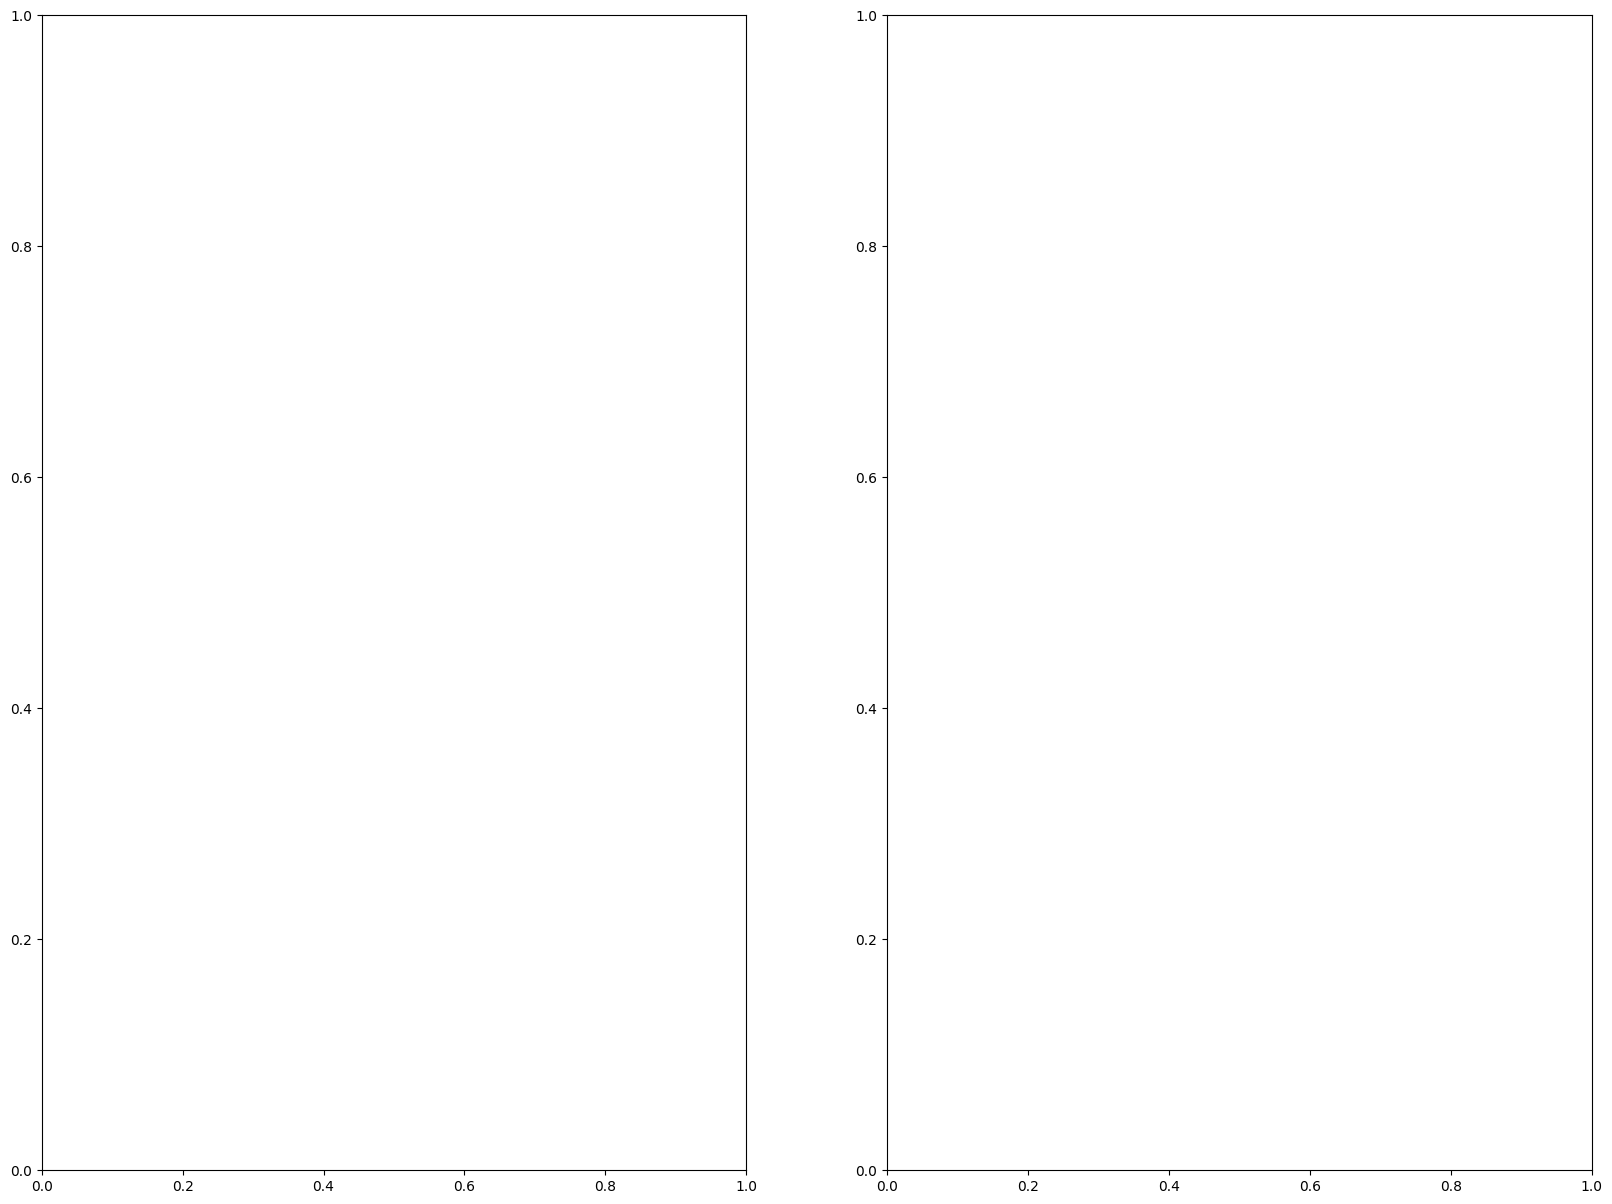

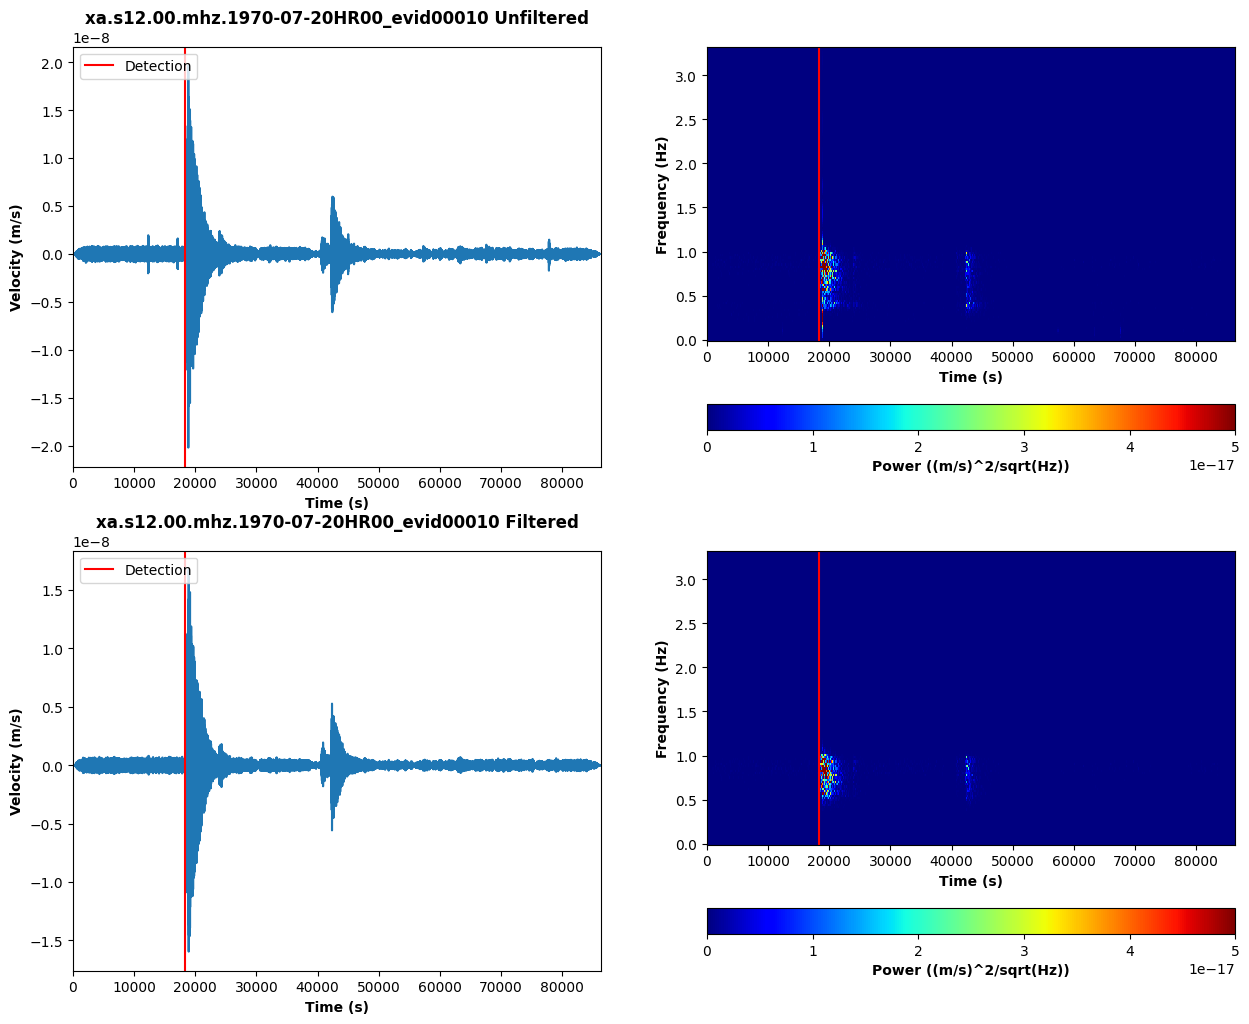

In [95]:
fig = plt.figure(figsize=(15, 12))

ax = plt.subplot(2, 2, 1)
ax.plot(tr_times, tr_data)

ax.axvline(x=quake_time_rel, color="red", label="Detection")
ax.legend(loc="upper left")

ax.set_title(f"{quake_filename} Unfiltered", fontweight="bold")
ax.set_xlim((min(tr_times), max(tr_times)))
ax.set_ylabel("Velocity (m/s)", fontweight="bold")
ax.set_xlabel("Time (s)", fontweight="bold")

ax2 = plt.subplot(2, 2, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)

ax2.set_xlim((min(tr_times), max(tr_times)))
ax2.set_xlabel(f"Time (s)", fontweight="bold")
ax2.set_ylabel("Frequency (Hz)", fontweight="bold")
ax2.axvline(x=quake_time_rel, c="red")

cbar = plt.colorbar(vals, orientation="horizontal")
cbar.set_label("Power ((m/s)^2/sqrt(Hz))", fontweight="bold")


ax = plt.subplot(2, 2, 3)
ax.plot(tr_times_filt, tr_data_filt)

ax.axvline(x=quake_time_rel, color="red", label="Detection")
ax.legend(loc="upper left")

ax.set_title(f"{quake_filename} Filtered", fontweight="bold")
ax.set_xlim((min(tr_times_filt), max(tr_times_filt)))
ax.set_ylabel("Velocity (m/s)", fontweight="bold")
ax.set_xlabel("Time (s)", fontweight="bold")

ax2 = plt.subplot(2, 2, 4)
vals = ax2.pcolormesh(t_filt, f_filt, sxx_filt, cmap=cm.jet, vmax=5e-17)

ax2.set_xlim((min(tr_times_filt), max(tr_times_filt)))
ax2.set_xlabel(f"Time (s)", fontweight="bold")
ax2.set_ylabel("Frequency (Hz)", fontweight="bold")
ax2.axvline(x=quake_time_rel, c="red")

cbar = plt.colorbar(vals, orientation="horizontal")
cbar.set_label("Power ((m/s)^2/sqrt(Hz))", fontweight="bold")

In [96]:
def get_mseed_files_list(path):
    return glob.glob(f"{path}/**/*.mseed", recursive=True)

def remove_evid_suffix(name):
    if match := re.match(r"(.*)_evid\d+(?:\.(?:csv|mseed))?", name):
        return match.group(1)

lunar_train_data_dir = "./data/lunar/training/data"
lunar_test_data_dir = "./data/lunar/test/data"

mars_train_data_dir = "./data/mars/training/data"
mars_test_data_dir = "./data/mars/test/data"

lunar_train_data_file_paths = get_mseed_files_list(lunar_train_data_dir)
lunar_test_data_file_paths = get_mseed_files_list(lunar_test_data_dir)

mars_train_data_file_paths = get_mseed_files_list(mars_train_data_dir)
mars_test_data_file_paths = get_mseed_files_list(mars_test_data_dir)

train_data_file_paths = lunar_train_data_file_paths + mars_train_data_file_paths
test_data_file_paths = lunar_test_data_file_paths + mars_test_data_file_paths

In [97]:
assert(len(lunar_train_data_file_paths) > 0)
assert(len(lunar_test_data_file_paths) > 0)
assert(len(mars_train_data_file_paths) > 0)
assert(len(mars_test_data_file_paths) > 0)

In [98]:
lunar_catalog_path = "./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
mars_catalog_path = "./data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv"

lunar_catalog = pd.read_csv(lunar_catalog_path)
assert len(lunar_catalog["filename"].tolist()) == len(lunar_train_data_file_paths)

lunar_events_per_file = defaultdict(int)
for filename in lunar_catalog["filename"]:
    lunar_events_per_file[remove_evid_suffix(filename)] += 1

mars_catalog = pd.read_csv(mars_catalog_path)
mars_catalog["filename"] = mars_catalog["filename"].apply(
    lambda name: name.replace(".csv", ".mseed")
)

mars_events_per_file = defaultdict(int)
for filename in mars_catalog["filename"]:
    mars_events_per_file[remove_evid_suffix(filename)] += 1

events_per_file = lunar_events_per_file | mars_events_per_file

print(sorted(events_per_file.items(), key=lambda kv: kv[1], reverse=True))

[('xa.s12.00.mhz.1970-07-20HR00', 2), ('xa.s12.00.mhz.1971-05-12HR00', 2), ('xa.s12.00.mhz.1972-07-17HR00', 2), ('xa.s12.00.mhz.1973-06-05HR00', 2), ('xa.s12.00.mhz.1974-07-06HR00', 2), ('xa.s12.00.mhz.1970-01-19HR00', 1), ('xa.s12.00.mhz.1970-03-25HR00', 1), ('xa.s12.00.mhz.1970-03-26HR00', 1), ('xa.s12.00.mhz.1970-04-25HR00', 1), ('xa.s12.00.mhz.1970-04-26HR00', 1), ('xa.s12.00.mhz.1970-06-15HR00', 1), ('xa.s12.00.mhz.1970-06-26HR00', 1), ('xa.s12.00.mhz.1970-09-26HR00', 1), ('xa.s12.00.mhz.1970-10-24HR00', 1), ('xa.s12.00.mhz.1970-11-12HR00', 1), ('xa.s12.00.mhz.1970-12-11HR00', 1), ('xa.s12.00.mhz.1970-12-27HR00', 1), ('xa.s12.00.mhz.1970-12-31HR00', 1), ('xa.s12.00.mhz.1971-01-15HR00', 1), ('xa.s12.00.mhz.1971-01-28HR00', 1), ('xa.s12.00.mhz.1971-01-29HR00', 1), ('xa.s12.00.mhz.1971-02-09HR00', 1), ('xa.s12.00.mhz.1971-03-25HR00', 1), ('xa.s12.00.mhz.1971-04-13HR00', 1), ('xa.s12.00.mhz.1971-04-17HR00', 1), ('xa.s12.00.mhz.1971-05-13HR00', 1), ('xa.s12.00.mhz.1971-05-23HR00', 1), 

In [99]:
# catalog = lunar_catalog.copy()[["filename", "time_abs(%Y-%m-%dT%H:%M:%S.%f)", "time_rel(sec)"]]
# catalog["filename"] = catalog["filename"].apply(remove_evid_suffix)
# catalog

16

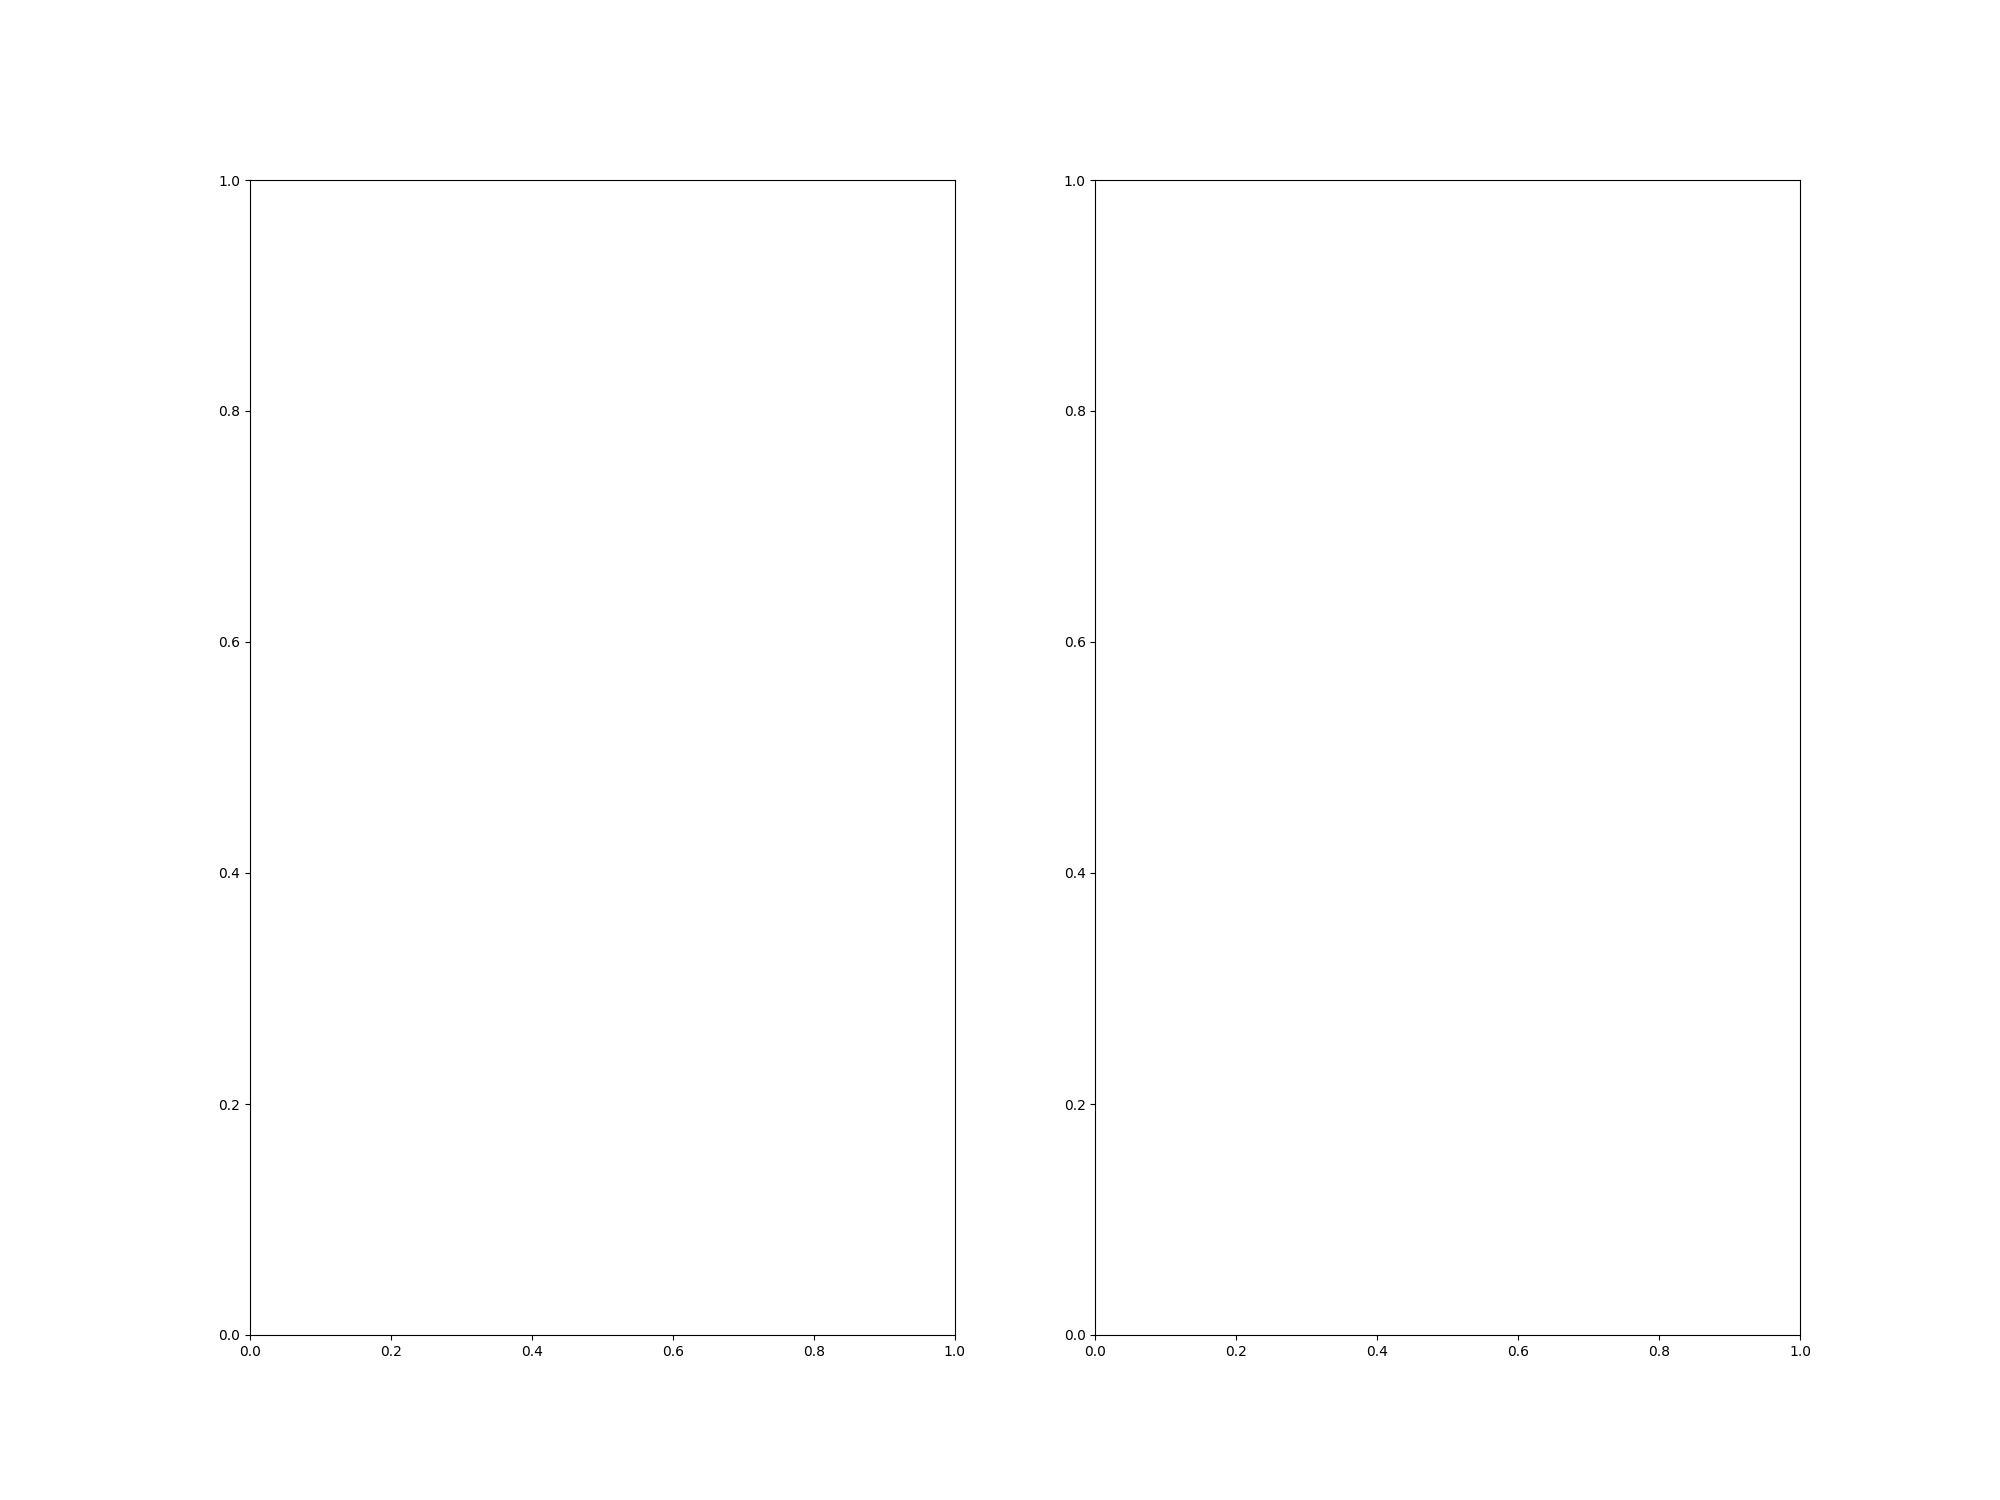

In [100]:
# Enable interactive plotting in the notebook
%matplotlib ipympl

x_coords_dict = {}  # Store x-coordinates for each file

# with open("test_data_catalog.csv", "r") as data:
#     for i, line in enumerate(csv.reader(data)):
#         if i == 0:
#             continue
#         x_coords_dict[line[0]] = eval(line[1])

# Global state
lines_dict = {}  # Store Line2D objects for each file

file_paths = mars_test_data_file_paths  # List of file paths
current_file_index = 0  # Current file being viewed
max_file_index = len(file_paths) - 1  # Maximum file index
current_quake_index = 0  # Current quake index for adding/modifying lines

# Function to load seismic data from mseed files
def load_mseed_file(filepath):
    st = obspy.read(filepath)
    trace = st.traces[0].copy()
    times = trace.times()
    data = trace.data
    stats = trace.stats
    return times, data, stats

# Function to visualize the seismic data and quake times
# Function to visualize the seismic data and quake times
def visualise_file(ax1, ax2, filepath, title, quake_times=[]):
    times, data, stats = load_mseed_file(filepath)

    # Clear the first axis and plot time series data
    ax1.clear()
    ax1.plot(times, data)

    # Add new quake lines if any
    for i, quake_time in enumerate(quake_times):
        ax1.axvline(x=quake_time, color="red", linestyle="--", label=f"Quake {i + 1}")

    if quake_times:
        ax1.legend(loc="upper left")

    ax1.set_title(f"{title}", fontweight="bold")
    ax1.set_xlim((min(times), max(times)))
    ax1.set_ylabel("Velocity (m/s)", fontweight="bold")
    ax1.set_xlabel("Time (s)", fontweight="bold")

    # Spectrogram
    f, t, sxx = signal.spectrogram(data, stats.sampling_rate)
    ax2.clear()  # Clear the previous spectrogram
    ax2.pcolormesh(t, f, sxx, cmap=cm.jet)

    # Redraw existing lines on the spectrogram
    for i, quake_time in enumerate(quake_times):
        ax2.axvline(x=quake_time, color="red", linestyle="--")

    ax2.set_xlim((min(times), max(times)))
    ax2.set_xlabel("Time (s)", fontweight="bold")
    ax2.set_ylabel("Frequency (Hz)", fontweight="bold")


# Handle mouse clicks to add or modify vertical quake lines
def on_click(event):
    global current_quake_index, lines_dict, x_coords_dict
    if event.inaxes and event.button == 2:  # Left mouse button click
        x = event.xdata
        current_file = os.path.basename(file_paths[current_file_index]).replace(".mseed", "")

        # Initialize storage for this file if not present
        if current_file not in lines_dict:
            lines_dict[current_file] = []
            x_coords_dict[current_file] = []

        # Modify an existing line or add a new one
        if current_quake_index >= 0 and current_quake_index < len(lines_dict[current_file]):
            # Update existing line
            lines_dict[current_file][current_quake_index].set_xdata([x, x])

        elif current_quake_index == len(lines_dict[current_file]):
            # Add a new line
            new_line = ax1.axvline(x=x, color="r", linestyle="--", label=f"Quake {current_quake_index + 1}")
            lines_dict[current_file].append(new_line)
            # Also add to the spectrogram
            ax2.axvline(x=x, color="red", linestyle="--")

        # Update x-coordinates for the current file
        x_coords_dict[current_file] = [line.get_xdata()[0] for line in lines_dict[current_file]]

        # Redraw and update legend
        update_plot()
        ax1.legend(loc="upper left")

# Handle key press events to switch files, modify or delete lines
def on_press(event):
    global current_quake_index, current_file_index, lines_dict, x_coords_dict
    current_file = os.path.basename(file_paths[current_file_index]).replace(".mseed", "")

    if event.key in set(map(str, range(1, 10))):
        # Select the quake index to modify (1-9), but restrict to the number of existing lines
        new_index = int(event.key) - 1
        if new_index <= len(lines_dict.get(current_file, [])):
            current_quake_index = new_index
        else:
            current_quake_index = -1  # Reset if out of bounds

    elif event.key == "delete":
        # Delete the current quake line if it exists
        if current_file in lines_dict and current_quake_index >= 0 and current_quake_index < len(lines_dict[current_file]):
            lines_dict[current_file][current_quake_index].remove()  # Remove from plot
            del lines_dict[current_file][current_quake_index]  # Remove from dictionary
            del x_coords_dict[current_file][current_quake_index]
            current_quake_index = -1

            # Update plot after deletion
            update_plot()  # Redraw the plot after deletion

    elif event.key == "left" and current_file_index > 0:
        # Move to previous file
        current_file_index -= 1
        current_quake_index = -1  # Reset quake index
        update_plot()

    elif event.key == "right" and current_file_index < max_file_index:
        # Move to next file
        current_file_index += 1
        current_quake_index = -1  # Reset quake index
        update_plot()

# Function to update the plot when switching files
def update_plot():
    filepath = file_paths[current_file_index]
    current_file = os.path.basename(filepath).replace(".mseed", "")
    title = current_file

    # Get stored quake times for the current file or empty list
    quake_times = x_coords_dict.get(current_file, [])

    # Visualize the seismic data and quake lines for the new file
    visualise_file(ax1, ax2, filepath, title, quake_times)

    plt.draw()

# Initial plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))  # Create subplots

# Connect mouse click and key press events
fig.canvas.mpl_connect("button_press_event", on_click)
fig.canvas.mpl_connect("key_press_event", on_press)

# Visualize the first file on startup
# visualise_file(ax1, ax2, file_paths[0], os.path.splitext(os.path.basename(file_paths[0]))[0])
# plt.show()

In [101]:
# import json

# with open("test_data_catalog.csv", "w", newline="") as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerow(["filename","time_rel(sec)"])
#     for key, value in x_coords_dict.items():
#         proper_list = json.loads(value)
#         times = list(map(lambda x: float(x), proper_list))
#         writer.writerow([key, times])

In [102]:
x_coords_dict

{}

In [126]:
test_data_catalog = pd.read_csv("test_data_catalog.csv")

X = []
for file_path in test_data_file_paths + train_data_file_paths:
    row = {}
    times, data, _ = load_mseed_file(file_path)

    file_name = os.path.basename(file_path)
    file_name_withoud_evid = remove_evid_suffix(file_name)
    file_name_without_extension = file_name.replace(".mseed", "")

    row["filename"] = file_name
    row["filename_without_evid"] = file_name_withoud_evid
    row["times"] = times
    row["data"] = data
    row["time_rel"] = []

    if file_name_without_extension in lunar_catalog["filename"].to_list():
        found_row = lunar_catalog.loc[lunar_catalog["filename"] == file_name_without_extension]
        value = found_row["time_rel(sec)"].item()
        row["time_rel"].append(value)
    elif file_name in mars_catalog["filename"].to_list():
        found_row = mars_catalog.loc[mars_catalog["filename"] == file_name]
        value = found_row["time_rel(sec)"].item()
        row["time_rel"].append(value)
    elif file_name_without_extension in test_data_catalog["filename"].to_list():
        found_row = test_data_catalog.loc[
            test_data_catalog["filename"] == file_name_without_extension
        ]
        row["time_rel"] = found_row["time_rel(sec)"].item()

    X.append(row)

X = pd.DataFrame(X)

In [127]:
pd.set_option("display.max_rows", 500)
print(X[X["filename"] == "xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed"])

                                         filename  \
105  xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed   

            filename_without_evid  \
105  xa.s12.00.mhz.1970-01-19HR00   

                                                 times  \
105  [0.0, 0.1509433962264151, 0.3018867924528302, ...   

                                                  data   time_rel  
105  [-6.153278962788711e-14, -7.70128843364098e-14...  [73500.0]  


In [128]:
X[X["time_rel"].apply(len) == 0]

,filename,filename_without_evid,times,data,time_rel
96,XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed,XB.ELYSE.02.BHV.2019-05-23HR02,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[-0.0, 0.00019864462531553602, -0.001629949058...",[]
97,XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed,XB.ELYSE.02.BHV.2019-07-26HR12,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 6.686134029993153e-05, 5.67963073810348e...",[]
98,XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed,XB.ELYSE.02.BHV.2019-07-26HR12,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 6.686134029993153e-05, 5.67963073810348e...",[]
99,XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed,XB.ELYSE.02.BHV.2019-09-21HR03,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[-0.0, -0.0003477903789540691, -0.002021502907...",[]
100,XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed,XB.ELYSE.02.BHV.2021-05-02HR01,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.0001445391690849273, 0.001533005468421...",[]
101,XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed,XB.ELYSE.02.BHV.2021-10-11HR23,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.0008688291210824519, 0.006072897068275...",[]
102,XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed,XB.ELYSE.02.BHV.2021-12-24HR22,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.002882599716235456, 0.0054220651000912...",[]
103,XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed,XB.ELYSE.02.BHV.2022-04-09HR22,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.00028421692670263965, 0.00104010046988...",[]
104,XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed,XB.ELYSE.02.BHV.2022-05-04HR23,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.0040756193600632535, 0.007310300940710...",[]


In [129]:
import ast

def fix_element(el):
    if isinstance(el, str):
        return ast.literal_eval(el)
    return el

X_fixed = X[X["time_rel"].apply(len) > 0].copy()
X_fixed["time_rel"] = X_fixed["time_rel"].apply(fix_element)

In [130]:
import numpy as np
import pandas as pd
import ast
from itertools import zip_longest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json


# Function to pad sequences, handling lists of floats
def pad_sequences(sequences, fillvalue=0):
    padded = []
    max_length = max(len(seq) for seq in sequences)

    for seq in sequences:
        # Pad with the fill value to match the max length
        padded_seq = seq + [fillvalue] * (max_length - len(seq))
        padded.append(padded_seq)

    return np.array(padded)

# Pad 'time_rel' to ensure uniform output sizes, using 0 as the fill value
y = pad_sequences(X_fixed["time_rel"].tolist(), fillvalue=0)

# Convert 'data' into a numpy array
X_data = np.array(X_fixed["data"].tolist())

# Reshape 'data' into a 3D array for LSTM input (samples, timesteps, features)
X_features = np.array([X_fixed["data"].tolist()]).reshape(len(X), len(X_fixed["data"][0]), 1)

# Check for NaN in the feature and target datasets
if np.isnan(X_features).any() or np.isnan(y).any():
    print("Features or targets contain NaN values before split.")
    print("NaN values in features: ", np.isnan(X_features).any())
    print("NaN values in targets: ", np.isnan(y).any())
    exit(1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Normalize the features using sklearn's StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Check for NaN values after conversion to tensors
if torch.isnan(X_train_tensor).any() or torch.isnan(y_train_tensor).any():
    print("NaN values detected in training tensors.")
    exit(1)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


# Define the LSTM model
class EarthquakeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(EarthquakeLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out is (batch_size, seq_len, hidden_size)
        lstm_out = lstm_out[:, -1, :]  # We take the output from the last time step
        output = self.fc(lstm_out)  # Final output (batch_size, output_size)
        return output


# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[2]  # Number of input features per time step
hidden_size = 64  # Number of hidden units in the LSTM
output_size = y_train.shape[1]  # Number of earthquake timestamps to predict
num_layers = 1  # Number of LSTM layers

model = EarthquakeLSTM(input_size, hidden_size, output_size, num_layers)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Set a reasonable learning rate

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Testing the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Plot the actual vs predicted timestamps for each output (earthquake timestamp)
for i in range(y_pred.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot(
        [np.nanmin(y_test[:, i]), np.nanmax(y_test[:, i])],
        [np.nanmin(y_test[:, i]), np.nanmax(y_test[:, i])],
        "r--",
        lw=2,
    )
    plt.xlabel("Actual Earthquake Timestamps")
    plt.ylabel("Predicted Earthquake Timestamps")
    plt.title(f"Actual vs Predicted Earthquake Timestamps (Output {i + 1})")
    plt.grid()
    plt.show()

# Evaluate the model (Mean Squared Error for each output)
for i in range(y_pred.shape[1]):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    print(f"Mean Squared Error for Output {i + 1}: {mse:.4f}")

TypeError: can only concatenate str (not "list") to str